### PyKGML: Quick Start Example
This notebook demonstrates the use of [**PyKGML**](https://github.com/AI4Agriculture/PyKGML_development), a Python libaray for efficient KGML development. 

In this example, we will learn how to predict GHG (CO<sub>2</sub>/N<sub>2</sub>O) fluxes using the provided dataset.

In [ ]:
# import necessary python library
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

### Import classes from PyKGML library
1. **dataset** The example dataset contains four components:  
    - co2_pretrain_data (Synthetic data of CO2 fluxes generated by ecosys)  
    - co2_finetune_data (Field observations of CO2 fluxes from flux towers)
    - n2o_pretrain_data (Synthetic data of N2O fluxes generated by ecosys)  
    - n2o_finetune_augment_data (Augmented chamber observations of N2O fluxes in a mesocosm environment)  

    The CO2 datasets are from Liu et al., 2024: https://www.nature.com/articles/s41467-023-43860-5  
    The N2O datasets are from Liu et al., 2022: https://doi.org/10.5194/gmd-15-2839-2022

2. From **time_series_models**, users can select one model among:  
    - Attention
    - GRUSeq2Seq
    - LSTMSeq2Seq
    - GRUSeq2SeqWithAttention
    - 1dCNN
    - RelPositionalEncoding
    - TimeSeriesTransformer
    - N2OGRU_KGML (This is the KGMLag-N2O model (structure only) from Liu et al., 2022)
    - RecoGRU_KGML (This is the KGMLag-CO2 model (structure only) from Liu et al., 2024)  

    **SequenceDataset** is a class that prepares the dataset as samples with a specified sequence length and stores them along with the corresponding labels.  
    It works with PyTorch’s **DataLoader** to create an iterable to enable easy access to the samples.


3. **kgml_lib** stores defined utility functions:
    - normalization (Z_norm, Z_norm_with_scaler, Z_norm_reverse), 
    - Loss function design (LossCompiler), 
    - Model structure design (ModelCompiler)

In [ ]:
from time_series_models import GRUSeq2SeqWithAttention, SequenceDataset
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # ignore duplicate library loading errors.

### Dataset information
1. Loading method  
The example dataset was standardized by Z-normalization and saved as a serialized disctionary object using torch.save().  
Torch.load() can be used to load the files: 'co2_pretrain_data.sav', 'co2_finetune_data.sav', 'n2o_pretrain_data.sav', 'n2o_finetune_augment_data.sav'.  
The keys in the loaded dataset will look like this:  
<pre>   
    ```python 
    co2_pretrain_data = {'X_train': X_train,  
                         'X_test': X_test,  
                         'Y_train': Y_train,  
                         'Y_test': Y_test,  
                         'y_scaler': y_scaler,  
                         'input_features':input_features,  
                         'output_features': output_features}   
    ``` </pre>
            
2. Dataset size and dimensions  
  - Input X shape: [sample, sequence_length, input_features]
  - Output Y shape: [sample, sequence_length, output_features]  
      
    1. co2_pretrain_data:  
        - 100 samples (one per site)
        - Each sample is a daily sequence over 18 years (6570) 
        - 19 input_features and 2 output_features  
          
    2. co2_finetune_data:  
        - One sample (11 sites were concatnated into one sequence due to varied sequence lengths)
        - A Daily sequence of total 124 site-years (45260 in length)
        - 19 input_features and 2 output_features  
             
    3. n2o_pretrain_data:  
        - 1980 samples (99 sites and 20 fertilizer rates at each site)
        - Each sample is a daily sequence over 18 years (6570 in length)
        - 16 input_features and 5 output_features  
          
    4. n2o_finetune_augment_data:  
        - 600 samples (6 sites and each has 1000 augmentation), 
        - Each sample is a daily sequence of 122 days over 3 years (366 in length)
        - 16 input_features and 5 output_features  

In [ ]:
# Load dataset
root_dir = '/Users/yufengyang/Library/CloudStorage/GoogleDrive-yang6956@umn.edu/My Drive/KGML/PyKGML/datasets/'
data_path = root_dir +  'CO2/' 
# for the N2O dataset: data_path = root_dir +  'N2O/'  
output_path = root_dir + 'test_results/CO2/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

co2_finetune_file = data_path + 'co2_finetune_data.sav'
data = torch.load(co2_finetune_file, weights_only=False)
print(data.keys())

dict_keys(['X_train', 'X_test', 'Y_train', 'Y_test', 'y_scaler'])


In [14]:
# Assign training and testing data. 
X_train, X_test, Y_train, Y_test = data['X_train'], data['X_test'], data['Y_train'], data['Y_test']
# y_scaler contains the means and stds. To reverse Y data to the original, use kgml.lib.Z_norm_reverse
y_scaler = data['y_scaler']

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, y_scaler.shape

(torch.Size([1, 37230, 19]),
 torch.Size([1, 37230, 2]),
 torch.Size([1, 8030, 19]),
 torch.Size([1, 8030, 2]),
 (2, 2))

In [9]:
# Set parameters for create a Module
num_input_features = 19
num_output_features = 2

input_dim = num_input_features
hidden_dim = 128
num_layers = 3
output_dim = num_output_features
dropout=0.2

### Model selections and their parameters:  

- LSTMSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)   

- GRUSeq2Seq(input_dim, hidden_dim, num_layers, output_dim) 

- Attention(input_dim, hidden_dim, num_layers, output_dim) 

- GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)   

- TemporalCNN(input_dim, hidden_dim, num_layers, output_dim, dropout) 

- CNNLSTM(input_dim, hidden_dim, num_layers, output_dim, dropout) 

- CNN_LSTM_Attension(input_dim, hidden_dim, num_layers, output_dim, dropout) 

- N2OGRU_KGML(input_dim, hidden_dim, num_layers, output_dim1, output_dim2, dropout) 

- RecoGRU_KGML(input_dim, hidden_dim, num_layers, output_dim, dropout) 


In [10]:
model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

In [11]:
# Create Pytorch dataloader
sequence_length = 365  # Use 365 consecutive days as a sample

# Create Dataset objects for training and testing.
train_dataset = SequenceDataset(X_train, Y_train, sequence_length)
test_dataset = SequenceDataset(X_test, Y_test, sequence_length)

# Create DataLoaders.
batch_size = 64
model.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model.test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# set hyperparameters for model training
learning_rate = 0.001
step_size = 40
max_epoch = 200
gamma = 0.8
# loss function can be from pytorch: nn.MSELoss(), nn.L1Loss(), or from kgml.lib: multiTaskWeighted_Loss
loss_function = nn.L1Loss()

model.train_model(loss_fun=loss_function, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/200 | LR: 0.001000, Train Loss: 0.7120, Test Loss: 0.6000
Epoch 2/200 | LR: 0.001000, Train Loss: 0.5874, Test Loss: 0.5059
Epoch 3/200 | LR: 0.001000, Train Loss: 0.4962, Test Loss: 0.4827
Epoch 4/200 | LR: 0.001000, Train Loss: 0.4704, Test Loss: 0.4452
Epoch 5/200 | LR: 0.001000, Train Loss: 0.4113, Test Loss: 0.3909
Epoch 6/200 | LR: 0.001000, Train Loss: 0.3779, Test Loss: 0.3709
Epoch 7/200 | LR: 0.001000, Train Loss: 0.3416, Test Loss: 0.3408
Epoch 8/200 | LR: 0.001000, Train Loss: 0.3209, Test Loss: 0.3231
Epoch 9/200 | LR: 0.001000, Train Loss: 0.3035, Test Loss: 0.3251
Epoch 10/200 | LR: 0.001000, Train Loss: 0.2943, Test Loss: 0.3122
Epoch 11/200 | LR: 0.001000, Train Loss: 0.2768, Test Loss: 0.2944
Epoch 12/200 | LR: 0.001000, Train Loss: 0.2619, Test Loss: 0.2908
Epoch 13/200 | LR: 0.001000, Train Loss: 0.2614, Test Loss: 0.2952
Epoch 14/200 | LR: 0.001000, Train Loss: 0.2558, Test Loss: 0.2840
Epoch 15/200 | LR: 0.001000, Train Loss: 0.2447, Test Loss: 0.2799
Epoc

In [ ]:
# model testing using test_dataset
model.test()

Test Loss: 0.1750


### Visualization
Basic functions for visualizing the model prediction incude:  
- plot_training_curves(): # plot the loss curves of training and testing  
- Vis_plot_prediction_result_time_series(y_scaler, output_feature_name): visualize the predicted sequence vs. the true values at a specific site and year
- Vis_scatter_prediction_result(y_scaler, output_feature_name): visualize the predicted values vs. true values in scatters


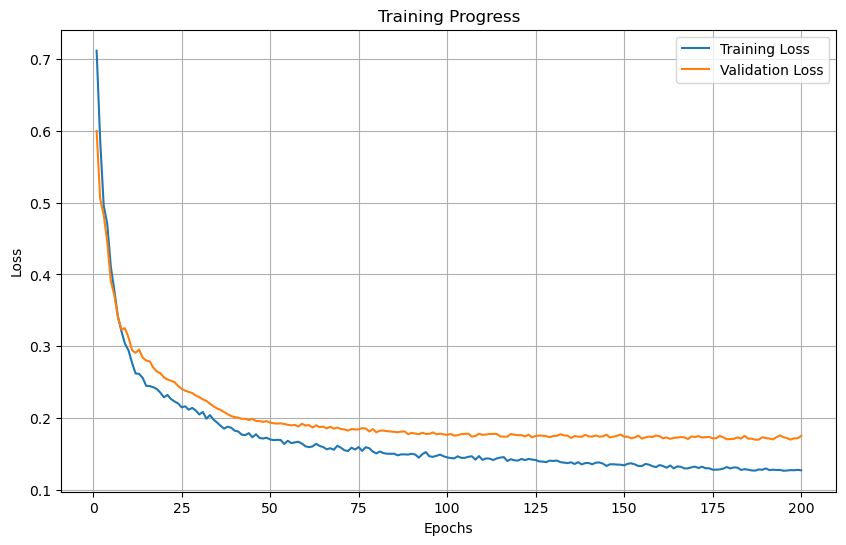

In [ ]:
model.plot_training_curves()

In [17]:
output_feature_name = ['NEE','RECO']
model.get_R2_score(y_scaler, output_feature_name)

Feature NEE R2 Score is: 0.936375464726363
Feature RECO R2 Score is: 0.8914221182159583


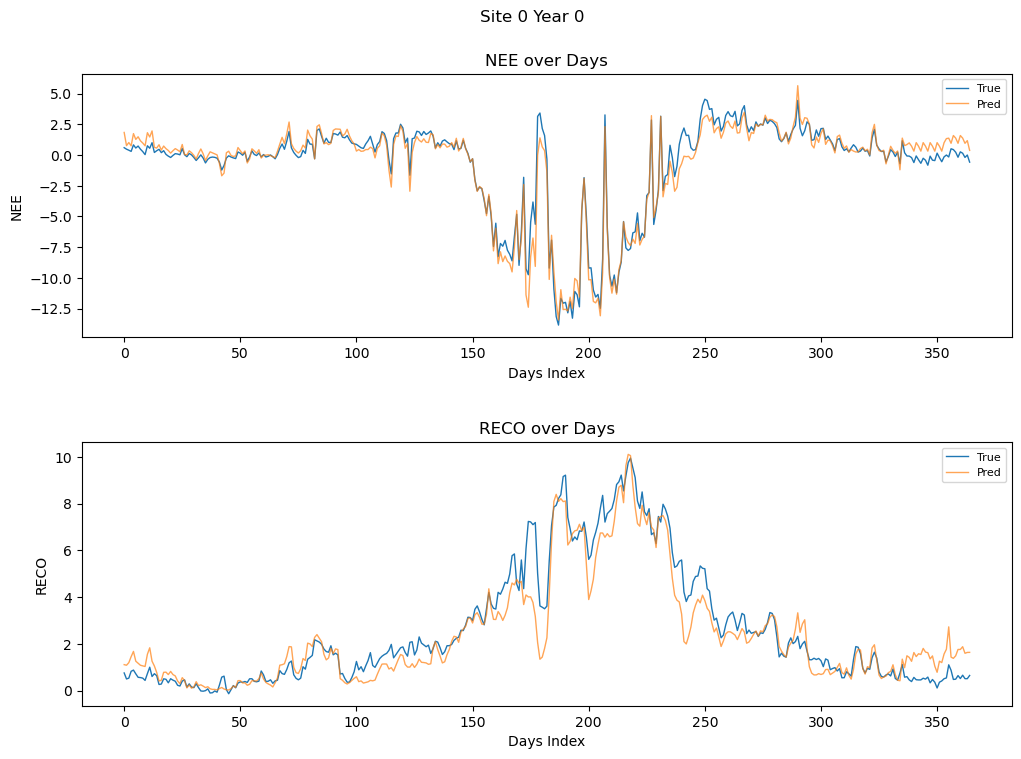

In [ ]:
model.Vis_plot_prediction_result_time_series(y_scaler, output_feature_name, site=0, year=0)

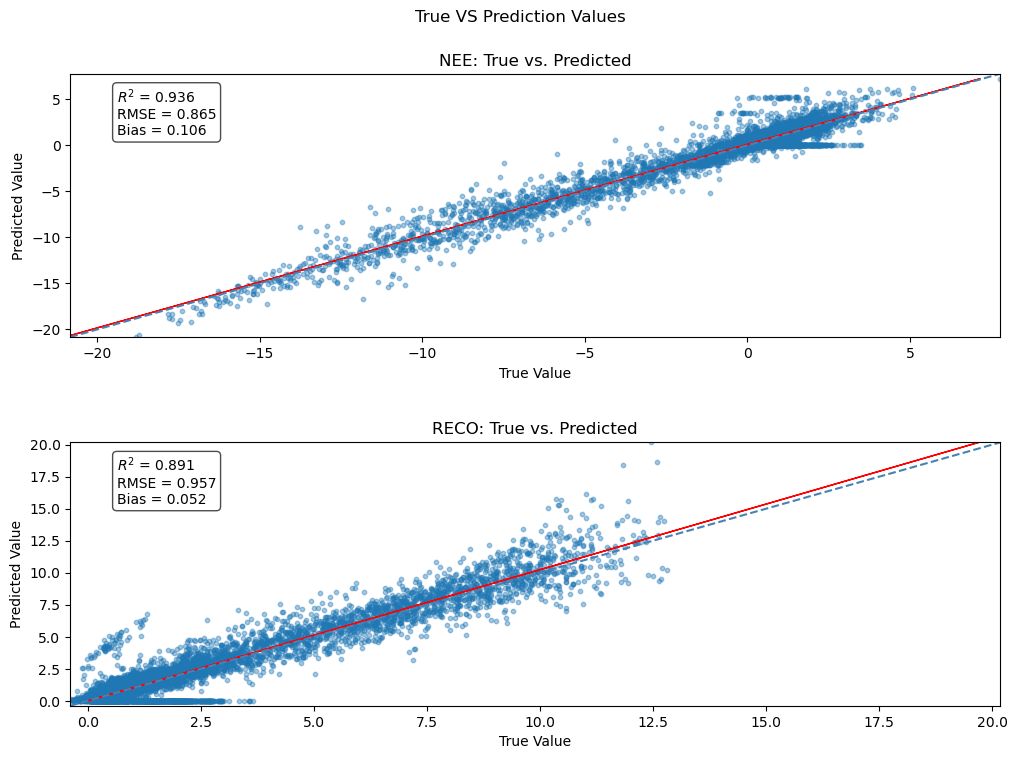

In [ ]:
model.Vis_scatter_prediction_result(y_scaler, output_feature_name)